In [1]:
import os
import re

from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI

from agent.utils.loader import load_processed_data

_ = load_dotenv(find_dotenv())
# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "self-correct"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"

In [2]:
meta_info = {
	"dataset_name": 'gsm8k',
	"mode": "self-improve",
	"base_mode": "pot",
	"model": "gpt-4o-mini-2024-07-18",
	"num_samples": -1,
	"top_p": 0.95,
	"temperature": 0,
	"seed": 42,
	"batch_size": 100
}
assert meta_info["mode"] == "self-improve"
assert meta_info["dataset_name"] in ["gsm8k", "math", "gsmhard", "tabmwp", "svamp"], "Invalid dataset name"

if meta_info["base_mode"] == "cot":
	processed_data_path = f"../../../output/inference/{meta_info['model']}/{meta_info['dataset_name']}/cot/num_samples_1000_top_p_0.95_temperature_0_seed_42.jsonl"
else:
	processed_data_path = f"../../../data/processed_data/{meta_info['dataset_name']}.jsonl"

dataset = load_processed_data(dataset_name=meta_info["dataset_name"], file_path=processed_data_path)
if meta_info["base_mode"] == "cot":
	dataset = dataset.remove_columns(["prediction", 'generation'])
model = ChatOpenAI(
	model_name=meta_info["model"],
	top_p=meta_info["top_p"],
	temperature=meta_info["temperature"],
	seed=meta_info["seed"],
	openai_api_base="https://api.chsdw.top/v1"
)



if meta_info["num_samples"] > 0:
	dataset = dataset.select(range(meta_info["num_samples"]))
print(dataset[10])

Generating train split: 0 examples [00:00, ? examples/s]

{'context': '', 'question': 'A new program had 60 downloads in the first month. The number of downloads in the second month was three times as many as the downloads in the first month, but then reduced by 30% in the third month. How many downloads did the program have total over the three months?', 'answer': '366'}


In [3]:
from langgraph.graph import add_messages
from langchain_core.messages import BaseMessage
from typing import Sequence
from typing_extensions import TypedDict, Annotated
from langgraph.managed.is_last_step import RemainingSteps


class State(TypedDict):
	question: str
	guidance: str
	remaining_steps: RemainingSteps
	messages: Annotated[Sequence[BaseMessage], add_messages]
	initial_answer: str
	fusion: str
	prediction: str

In [4]:
from langchain_core.prompts import ChatPromptTemplate

guidance_prompt = ChatPromptTemplate.from_messages(
	[
		(
			"system",
			"You are a question planner and error prone points identifier. Given a question or problem, your job is to come up with a step by step plan, and you should also identify the most error-prone points for each step, following them closely behind each step. The plan and the error prone points will then be used to guide the selection of subsequent tools and the corresponding tool inputs. The tool results should always be considered as reliable. Do not add any superfluous steps. Make sure that each step has all the information needed - do not skip steps. You should focus on the logic of how to solve the problem, rather than actually solving it."
		),
		(
			"user",
			"Question: {question}"
		)
	])
guidance_generator = guidance_prompt | model


async def guidance_node(state: State) -> State:
	assert state["question"] is not None, "Question is required"
	question:str = state["question"]
	guidance:AIMessage = await guidance_generator.ainvoke(input={"question": question})
	state["guidance"] = guidance.content
	return state

In [5]:
from langchain_core.messages import AIMessage
from langchain_community.utilities.wikidata import WikidataAPIWrapper
from langgraph.prebuilt import ToolNode
from agent.utils.tools import GoogleSearchTool, GoogleKnowledgeGraphTool, WikidataTool, WikipediaTool, python_interpreter

google_search = GoogleSearchTool()
google_knowledge_graph = GoogleKnowledgeGraphTool()
wikidata = WikidataTool(api_wrapper=WikidataAPIWrapper())
wikipedia = WikipediaTool()
tools = [google_search, google_knowledge_graph, wikipedia, wikidata, python_interpreter]

model_with_tools = model.bind_tools(tools)


In [6]:

from typing import Literal

critique_prompt = ChatPromptTemplate.from_messages([
	(
		"system",
		"You are a reactive agent. Given a question or problem, your job is to select the appropriate tools to answer the question or solve the problem. You should consider the guidance provided by the question planner and error prone points identifier, and the tool results are reliable. If you find the answer from the tool results, you should provide the answer."
	),
	(
		"user",
		"Question: {question}"
		"Guidance: {guidance}"
	)
])

async def critique_node(state: State):
	assert state["question"] is not None, "Question is required"
	assert state["guidance"] is not None, "Guidance is required"
	question:str = state["question"]
	guidance:str = state["guidance"]
	messages:list[BaseMessage] = []
	if len(state["messages"]) == 0:
		messages = critique_prompt.invoke(input={"question": question, "guidance": guidance}).to_messages()
		critique:AIMessage = await model_with_tools.ainvoke(input=messages)
		messages.append(critique)
	else:
		critique:AIMessage = await model_with_tools.ainvoke(input=state["messages"])
		messages.append(critique)
	return {"messages": messages}

# Define our tool node
tool_node = ToolNode(tools)

fusion_prompt = ChatPromptTemplate.from_messages(
	[
		(
			"system",
			"You are a fusion agent. Given a question or problem and based on the critique process, your job is to fuse the tool results and then revise your final answer. "
			"Your response should contains two part, the first part is the fusion of the Revising Process and the second part is the final answer. In the fusion part, you should extract the information from the tool result and also indicate how you obtained the information.(which tool, which part of the result) In the final answer, "
			"do not include any explanations, context, or additional information. Just focus on delivering the exact answer as concisely as possible!!! "
			"There is no need to answer the question in the form of a complete sentence, just provide the answer in the form of a noun, time, entity, single number, yes or no, etc."
		),
		(
			"placeholder",
			"{messages}"
		),
		(
			"user",
			"Now based on the previous information, please fuse the tool results and revise your answer. Use the XML tag <fusion></fusion> to indicate the fusion part and <answer></answer> to indicate the final answer part."
		)
	])
fusion_generator = fusion_prompt | model

async def fusion_node(state: State) -> State:
	assert state["question"] is not None, "Question is required"
	assert state["guidance"] is not None, "Guidance is required"
	critique_messages:Sequence[BaseMessage] = state["messages"][1:]
	response:AIMessage = await fusion_generator.ainvoke(input={"messages": critique_messages})
	fusion_matches = re.findall(r"<fusion>(.*?)</fusion>", response.content, re.DOTALL)
	answer_matches = re.findall(r"<answer>(.*?)</answer>", response.content, re.DOTALL)
	if fusion_matches:
		state["fusion"] = fusion_matches[0]
	else:
		state["fusion"] = response.content
	if answer_matches:
		state["prediction"] = answer_matches[0]
	else:
		state["prediction"] = "None"

	return state

# Define the conditional edge that determines whether to continue or not
def should_continue(state: State) -> Literal["fuse", "tools"]:
	if state["remaining_steps"] <= 2:
		return "fuse"
	messages = state["messages"]
	last_message = messages[-1]
	# If there is no function call, then we finish
	if last_message.tool_calls:
		return "tools"
	# Otherwise if there is, we continue
	else:
		return "fuse"

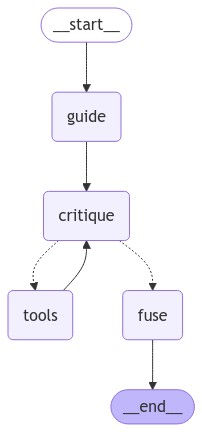

In [7]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)
workflow.add_node("guide", guidance_node)
workflow.add_node("critique", critique_node)
workflow.add_node("tools", tool_node)
workflow.add_node("fuse", fusion_node)

workflow.set_entry_point("guide")
workflow.add_edge("guide", "critique")
workflow.add_edge("tools", "critique")
workflow.add_conditional_edges("critique", should_continue)
workflow.add_edge("fuse", "__end__")

app = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
from tqdm.asyncio import tqdm_asyncio, tqdm
import os
import json
import logging
import nest_asyncio

# 配置logger
logging.basicConfig(
    level=logging.ERROR,  # 设置日志级别
    format='%(asctime)s - %(levelname)s - %(message)s',  # 设置日志格式
    handlers=[
        logging.FileHandler("inference.log"),  # 将日志输出到文件
        logging.StreamHandler()  # 也输出到控制台
    ]
)

logger = logging.getLogger("InferenceLogger")

nest_asyncio.apply()
results = []
batch_size = 100
save_results_path = f"../../../output/inference/{meta_info['model']}/{meta_info['dataset_name']}/{meta_info['mode']}/{meta_info['base_mode']}_num_samples_{meta_info['num_samples']}_top_p_{meta_info['top_p']}_temperature_{meta_info['temperature']}_seed_{meta_info['seed']}.jsonl"

async def process(item):
    try:
        state = await app.ainvoke({**item, "messages": []})
        state["messages"] = [message.pretty_repr() for message in state["messages"]]
        logger.info(f"Processed item: {item}")
        return {**item, **state}
    except Exception as e:
        logger.error(f"Error processing item: {item}. Error: {e}")
        return {**item, "prediction": "None"}

async def self_improve_inference() -> None:
    error_indices = []  # 用于记录包含 "ERROR" 的条目索引

    # 读取已有结果或初始化文件
    if os.path.exists(save_results_path):
        logger.info(f"Loading existing results from {save_results_path}")
        with open(save_results_path, 'r') as file:
            for idx, line in enumerate(file):
                result = json.loads(line)
                results.append(result)
                # 检查是否存在 "prediction: ERROR"
                if "None" == result.get("prediction"):
                    error_indices.append(idx)
    else:
        folder_path = os.path.dirname(save_results_path)
        os.makedirs(folder_path, exist_ok=True)
        logger.info(f"Created directory for results: {folder_path}")

    # 重新推理错误的数据
    if error_indices:
        logger.warning(f"Found {len(error_indices)} ERROR entries. Retrying inference...")
        error_data = [dataset[idx] for idx in error_indices]
        new_results = await tqdm_asyncio.gather(*(process(item) for item in error_data))
        # 更新原始结果
        for i, new_result in zip(error_indices, new_results):
            results[i] = new_result

    # 使用tqdm进度条显示进度，设置desc为提示信息
    bar = tqdm(total=dataset.num_rows, desc="Processing batches", position=0, dynamic_ncols=True)

    for idx in range(len(results), dataset.num_rows, batch_size):
        batch = dataset.select(range(idx, min(idx + batch_size, dataset.num_rows)))
        batch_results = await tqdm_asyncio.gather(*(process(item) for item in batch))
        results.extend(batch_results)

        # 更新进度条，进度条更新为当前批次的长度
        bar.update(batch_size)
        logger.info(f"Processed batch starting at index {idx}")

        # 保存结果
        with open(save_results_path, 'w') as file:
            for result in results:
                file.write(json.dumps(result) + "\n")
        logger.info(f"Saved results to {save_results_path}")

    bar.close()  # 完成处理后关闭进度条


In [12]:
await self_improve_inference()

Processing batches:   0%|          | 0/1000 [00:00<?, ?it/s]


In [13]:
# 保存结果
with open(save_results_path, 'w') as file:
	for result in results:
		file.write(json.dumps(result) + "\n")
logger.info(f"Saved results to {save_results_path}")